In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 51.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from math import log10, sqrt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
# Function to generate ECFP fingerprint from SMILES
def generate_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return ecfp

In [ ]:
chembl_data = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/preprocessed_train.csv')
chembl_data.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL3968119,IC50,'=',675.9,nM,6.17,CHEMBL3887888,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886488,675.9,6.17,CC(C)Nc1cc(Nc2ccc3ncsc3c2)ncc1-c1nnc(-c2ccc(F)...
1,CHEMBL3966110,IC50,'=',5.1,nM,8.29,CHEMBL3887118,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886172,5.1,8.29,CC(C)Nc1cc(-n2ncc3cc(C#N)cnc32)ncc1C(=O)NC1CCN...
2,CHEMBL4109180,IC50,'=',25.0,nM,7.60,CHEMBL3887893,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886492,25.0,7.60,O=c1[nH]c(N2CCN(c3cccc(Cl)n3)CC2)nc(N[C@@H]2CC...
3,CHEMBL4107475,IC50,'=',14.0,nM,7.85,CHEMBL3887118,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886172,14.0,7.85,CC(C)Nc1cc(-n2ccc3cc(CNC(=O)CC4CCOCC4)cnc32)nc...
4,CHEMBL4114259,IC50,'=',145.0,nM,6.84,CHEMBL3887893,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886492,145.0,6.84,CC1(C)CN(c2nc(N[C@@H]3CCCNC3)c(-c3nc4ccccc4s3)...


In [ ]:
num_chembl = len(chembl_data['Assay ChEMBL ID'].unique())
num_smiles = len(chembl_data['Smiles'].unique())

print('Number of Assay ChEMBL IDs', num_chembl)
print('Number of Smiles', num_smiles)

Number of Assay ChEMBL IDs 69
Number of Smiles 1839


In [ ]:
chembl_data.loc[:, 'ECFP'] = chembl_data['Smiles'].apply(generate_ecfp)

In [ ]:
val_data = chembl_data.iloc[:390]  # 상위 390개 행을 선택
train_data = chembl_data.iloc[390:]  # 나머지 행을 선택

In [ ]:
val_x = val_data['ECFP']
val_y = val_data['pIC50']

train_x = train_data['ECFP']
train_y = train_data['pIC50']

In [ ]:
val_x = np.stack(val_x.values)
train_x = np.stack(train_x.values)

In [ ]:
print("Validation X Shape:", val_x.shape)
print("Training X Shape:", train_x.shape)

Validation X Shape: (390, 2048)
Training X Shape: (1449, 2048)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
# 최적화된 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=CFG['SEED']),
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    verbose=2,
    n_jobs=1,
    random_state=CFG['SEED']
)

# 모델 학습 및 최적 하이퍼파라미터 탐색
random_search.fit(train_x, train_y)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   5.4s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   6.6s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   5.6s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   5.4s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   7.1s
[CV] END bootstrap=True, max_depth=14, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=  11.7s
[CV] END bootstrap=True, max_depth=14, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=  11.4s
[CV] END bootstrap=True, max_depth=14, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=  12.5s
[CV] END 

In [ ]:
# 예측값 계산
train_y_pred = best_model.predict(train_x)
val_y_pred = best_model.predict(val_x)

# RMSE 계산
train_rmse = np.sqrt(mean_squared_error(train_y, train_y_pred))
val_rmse = np.sqrt(mean_squared_error(val_y, val_y_pred))

# 결과 출력
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

Training RMSE: 0.4405
Validation RMSE: 0.6019


In [ ]:
def pIC50_to_IC50(pic50_values):
    return 10 ** (9 - pic50_values)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/preprocessed_test.csv')

In [ ]:
test.loc[:, 'ECFP'] = test['Smiles'].apply(generate_ecfp)

In [ ]:
test_x = test['ECFP']
test_x = np.stack(test_x.values)
test_y = test['pIC50']

In [ ]:
test_y_pred = best_model.predict(test_x)

In [ ]:
test_y_pred, test_y = pIC50_to_IC50(test_y_pred), pIC50_to_IC50(test_y)

In [ ]:
# RMSE 계산
rmse = sqrt(mean_squared_error(test_y, test_y_pred))

# Normalized RMSE 계산
normalized_rmse = rmse / (np.max(test_y) - np.min(test_y_pred))

# Absolute Error for IC50_nm
absolute_error = np.abs(test_y - test_y_pred)

# Correct Ratio 계산 (절대 오차가 0.5 이하인 비율)
correct_ratio = np.mean(absolute_error <= 0.5)

# 종합 점수 계산
score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

print(f"Normalized RMSE (A): {normalized_rmse}")
print(f"Correct Ratio (B): {correct_ratio}")
print(f"Score: {score}")

Normalized RMSE (A): 0.10053082946738079
Correct Ratio (B): 0.02654867256637168
Score: 0.46300892154949547


In [ ]:
submit_test = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/test.csv')


In [ ]:
submit_test.loc[:, 'ECFP'] = submit_test['Smiles'].apply(generate_ecfp)
stest_x = submit_test['ECFP']
stest_x = np.stack(stest_x.values)

In [ ]:
stest_y_pred = best_model.predict(stest_x)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/sample_submission.csv')
submit['IC50_nM'] =pIC50_to_IC50(stest_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,158.818668
1,TEST_001,48.410335
2,TEST_002,28.476136
3,TEST_003,31.935151
4,TEST_004,36.305165


In [ ]:
submit.to_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/submit_v3.csv', index=False)

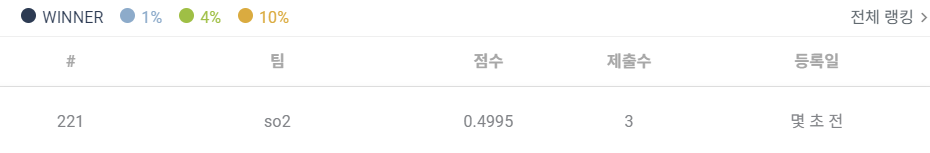